In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [16]:
def generate_evolution(logReturn, allocation, T_rebalancement=-1):
    nb_periods = logReturn.shape[0]
    nb_stocks = logReturn.shape[1]
    
    evolution = logReturn * 0.0
    
    if T_rebalancement == -1:
        # Buy and hold strategy
        evolution = np.exp(np.cumsum(logReturn)) * allocation
    else:
        # Rebalancing strategy
        evolution.iloc[:T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[:T_rebalancement, :])) * allocation
        
        for i in range(T_rebalancement, nb_periods, T_rebalancement):
            evolution.iloc[i:i+T_rebalancement, :] = np.exp(np.cumsum(logReturn.iloc[i:i+T_rebalancement, :])) * evolution.iloc[i-1, :].sum() * allocation
        last_period = (nb_periods//T_rebalancement)*T_rebalancement
        evolution.iloc[last_period:, :] = np.exp(np.cumsum(logReturn.iloc[last_period:, :])) * evolution.iloc[last_period-1, :].sum() * allocation
    
    return evolution

Paramètres = {

    "Begin date" :
    "End date" :
    "Returns" :
    "Volatilities" :
    "Correlation matrix" :
    "Allocation" :
    "Rebalancing period" :
}

In [ ]:
class Simulation:
    def __init__(self, nb_scenarios, model, strategie, parametres):
        if not isinstance(nb_scenarios, int):
            raise ValueError("nb_scenarios must be an integer")
        if model not in ["BS", "On verra"]:
            raise ValueError("model must be either 'BS' or 'On verra'")
        if strategie not in ["Buy and hold", "Rebalancing"]:
            raise ValueError("strategie must be either 'Buy and hold' or 'Rebalancing")
        self.nb_scenarios = nb_scenarios
        self.model = model
        self.strategie = strategie
        self.parametres = parametres
        #self.generate_scenarios()
        #self.generate_evolutions()

    def generate_scenarios(self):
        nb_scenarios = self.nb_scenarios
        nb_stocks = len(self.parametres["Returns"])
        # Génération des dates excluant les samedis et dimanches
        dates = pd.date_range(start=self.parametres["Begin date"], end=self.parametres["End date"], freq='B')
        nb_periods = len(dates)
        # Calcul du facteur d'ajustement pour les volatilities
        delta_t = dates.to_series().diff().dt.days[1:] / 365.25
        delta_t = np.insert(delta_t, 0, 0)
        adjustment_factor = np.sqrt(delta_t)
        
        if self.model == "BS":
            volatilities = self.parametres["Volatilities"]
            returns = self.parametres["Returns"]
            # Génération de scénarios de log-rendements
            log_returns = np.random.normal(0, 1, (nb_periods, nb_stocks, nb_scenarios))
            cholesky_matrix = np.linalg.cholesky(self.parametres["Correlation matrix"])
            for i in range(self.nb_scenarios):
                log_returns[:, :, i] = log_returns[:, :, i] @ cholesky_matrix.T
            log_returns = log_returns * (volatilities.values[:, None] * adjustment_factor[:, None, None])
            # Ajout du rendement moyen annuel
            mean_returns = (returns.values[:, None] / 256.2305133079848) * delta_t[:, None, None]
            log_returns += mean_returns
            self.scenarios = {f'Scenario {i+1}': pd.DataFrame(log_returns[:, :, i], index=dates, columns=volatilities.index) for i in range(nb_scenarios)}

    def generate_evolutions(self):
        nb_periods = self.scenarios["Scenario 1"].shape[0]
        nb_stocks = self.scenarios["Scenario 1"].shape[0]
        T_rebalancement = self.parametres["Rebalancing period"] if self.strategie == "Rebalancement" else -1
        allocation = self.parametres["Allocation"]
        self.evolutions = {f'Evolution {i+1}' : generate_evolution(self.scenarios[f"Scenario {i+1}"], allocation, T_rebalancement) for i in range(self.nb_scenarios)}



In [19]:
if True :
    # Create dictionary to store dataFrames for the 40 CAC40 companies
    Data10y_dic = {}

    # Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
    directory = "Data/CAC40 daily 10y"
    files = [f for f in os.listdir(directory) if 'Data' in f]
    # Process each file
    for file in files:
        # Get company name (first word before '_')
        company = file.split('_')[0]
        
        # Read the file with tab separator
        df = pd.read_csv(os.path.join(directory, file), sep='\t')
        
        # Convert first column to datetime and set as index
        df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

        df = df.drop('date', axis=1)  # Remove the original date column
        df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
        
        # Store in dictionary
        Data10y_dic[company] = df

    print(f"Loaded {len(Data10y_dic)} companies' data")

    # Create list of DataFrames with only 'clot' column
    dfs = [df['clot'] for df in Data10y_dic.values()]
    histo_CAC40 = pd.concat(dfs, axis=1, keys=Data10y_dic.keys())
    histo_CAC40 = histo_CAC40.sort_index()

    print(f"Shape of historical data: {histo_CAC40.shape}")
    print("\nFirst few rows:")
    # Drop rows with NaN values
    histo_CAC40_woNaN = histo_CAC40.dropna()
    print(f"Shape after dropping NaN rows: {histo_CAC40_woNaN.shape}")
    data = histo_CAC40_woNaN
    # Calcul du vecteur de rendement moyen annuel
    mu_annuel = np.log((data.iloc[-1, :]/data.iloc[0,:])) / (data.index[-1] - data.index[0]).days * 365.25
    delta_année = data.index.to_series().diff().dt.days.iloc[1:] / 365.25
    deltat_r = pd.DataFrame(delta_année.values[:, None] * mu_annuel.values, columns=mu_annuel.index, index=delta_année.index)
    nb_jour_pan = data.shape[0] / (data.index[-1] - data.index[0]).days * 365.25
    Volatilite_annuel = np.sqrt((np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).var() * nb_jour_pan)
    mat_correlation = (np.log((data/data.shift(1)).iloc[1:,:]) - deltat_r).corr()

    nb_stocks = 40
    allocations_EW = np.ones(nb_stocks) / nb_stocks

# Import the weights data of CAC40
CAC40_weights_df = pd.read_csv('Data/Poids des entreprises dans le CAC40.csv', sep=';').set_index('Societe')
# Convert string values to float
CAC40_weights = CAC40_weights_df.iloc[0, :].str.replace(',', '.').astype(float).values


Loaded 40 companies' data
Shape of historical data: (2562, 40)

First few rows:
Shape after dropping NaN rows: (1733, 40)


In [ ]:
parametres_BuyH = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
}
simulation_BuyH = Simulation(nb_scenarios=50, model="BS", strategie="Buy and hold", parametres=parametres_BuyH)
simulation_BuyH.generate_scenarios()
simulation_BuyH.generate_evolutions()

parametres_Rebal21 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
    "Rebalancing period": 21
}
simulation_Rebal21 = Simulation(nb_scenarios=50, model="BS", strategie="Rebalancing", parametres=parametres_Rebal21)
simulation_Rebal21.scenarios = simulation_BuyH.scenarios
simulation_Rebal21.generate_evolutions()

parametres_Rebal5 = {
    "Begin date": '2025-03-10',
    "End date": '2035-03-10',
    "Returns": mu_annuel,
    "Volatilities": Volatilite_annuel,
    "Correlation matrix": mat_correlation,
    "Allocation": allocations_EW,
    "Rebalancing period": 5
}
simulation_Rebal5 = Simulation(nb_scenarios=50, model="BS", strategie="Rebalancing", parametres=parametres_Rebal5)
simulation_Rebal5.scenarios = simulation_BuyH.scenarios
simulation_Rebal21.generate_evolutions()

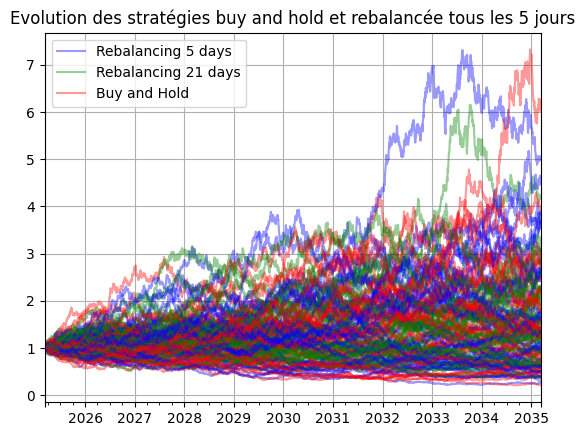

In [39]:
lines = []
evolution_rebal5 = simulation_Rebal5.evolutions
evolution_BuyH = simulation_BuyH.evolutions
evolution_rebal21 = simulation_Rebal21.evolutions

for evolution_name, evolution_data in evolution_rebal5.items():
    lines.append(evolution_data.sum(axis=1).plot(color="blue", alpha=0.4, label="Rebalancing 5 days"))
    lines.append(evolution_rebal21[evolution_name].sum(axis=1).plot(color="green", alpha=0.4, label="Rebalancing 21 days"))
    lines.append(evolution_BuyH[evolution_name].sum(axis=1).plot(color="red", alpha=0.4, label="Buy and Hold"))

plt.title("Evolution des stratégies buy and hold et rebalancée tous les 5 jours")
plt.grid()

# Get unique legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()


In [33]:
evolution_BuyH

{'Evolution 1':                ACCOR    AIRBUS  AIRLIQUIDE  ARCELORMITTAL       AXA  \
 2025-03-10  0.025000  0.025000    0.025000       0.025000  0.025000   
 2025-03-11  0.024734  0.024539    0.024887       0.024006  0.024313   
 2025-03-12  0.024585  0.024477    0.024790       0.023775  0.024053   
 2025-03-13  0.024446  0.024342    0.025170       0.023792  0.024151   
 2025-03-14  0.024473  0.024361    0.024920       0.023534  0.023677   
 ...              ...       ...         ...            ...       ...   
 2035-03-05  0.017472  0.005843    0.013743       0.010836  0.012836   
 2035-03-06  0.017167  0.005729    0.013693       0.010822  0.012924   
 2035-03-07  0.017429  0.005815    0.013748       0.010589  0.012635   
 2035-03-08  0.017106  0.005695    0.013670       0.010350  0.012535   
 2035-03-09  0.017333  0.005797    0.013677       0.010114  0.012686   
 
             BNPPARIBAS  BOUYGUES  BUREAUVERITAS  CAPGEMINI  CARREFOUR  ...  \
 2025-03-10    0.025000  0.025000       